This notebook will load in the needed data from the milestoning simulation and save the cleaned data into a pair of tables for the milestoning coordinates and restraint parameters respectively.

If you are running this on google colab (or another cloud based site) you will need to clone the repository using the cell below (uncomment and run).

In [ ]:
#!git clone https://github.com/wesleymsmith/Milestoning_Analysis.git

In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import tqdm
import copy
import gc
import sys
import os
import f90nml
import seaborn as sns

import bokeh
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource, CDSView, GroupFilter, HoverTool
from bokeh.plotting import figure, show
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral11

from bokeh.models.mappers import CategoricalColorMapper

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import scipy as sp
from scipy.sparse import linalg

import plotly as ply
from plotly import graph_objs as go
ply.io.renderers.default="notebook"

In [2]:
testData=pd.read_csv('Simulation_Milestone_Coordinate_Data.MultiRepI.csv')
testData.tail()

,Window,Rep,Time,Rst06_X,Rst06_Y,Rst07_Z,Rst08_Z,X_Index
16305369,52,5,2497500.0,11.402,29.513,4.087,114.340,52
16305370,52,5,2498000.0,11.208,29.527,3.605,114.833,52
16305371,52,5,2498500.0,11.018,29.404,4.106,114.323,52
16305372,52,5,2499000.0,11.113,29.756,3.739,114.689,52
16305373,52,5,2499500.0,11.500,29.848,3.727,114.714,52


In [3]:
testData['R']=np.sqrt(testData.Rst06_X**2+testData.Rst06_Y**2)
testData=testData.query('R<=30')
print testData.head()

   Window  Rep    Time  Rst06_X  Rst06_Y  Rst07_Z  Rst08_Z  X_Index          R
0       0    1     0.0    4.291   17.350  107.903   10.456        0  17.872750
1       0    1   500.0    4.117   17.984  108.105   10.275        0  18.449226
2       0    1  1000.0    4.162   17.821  108.509    9.857        0  18.300554
3       0    1  1500.0    4.621   17.773  107.792   10.539        0  18.363909
4       0    1  2000.0    4.761   17.909  108.495    9.874        0  18.531039


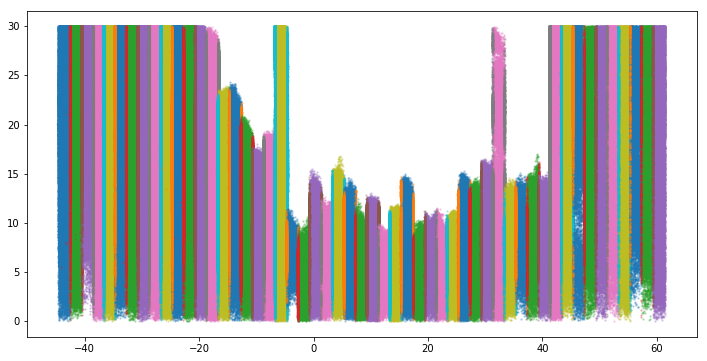

In [4]:
#window 1 to 6, rst07=138.6, rst08=6.74
#window 7 to 62, rst07=138.5, rst08=20.2
#window 63 to 69, rst07=153.2, rst08=20.2

#window 1-42, rst08
#window 43-69, rst07

#window 1-34, rst08 rst07=138.5, rst08=20.2
#window 35-56, rst07
#rMax=np.max([
    #np.sqrt(testData.Rst07_X**2+testData.Rst07_Y**2).max(),
    #np.sqrt(testData.Rst08_X**2+testData.Rst08_Y**2).max()
#])

rstMapper=np.concatenate([
    ['Rst08']*34,
    ['Rst07']*(55-34+1),
    ['Rst06']*(56)
])
zWaterMap=np.zeros(56)
zWaterMap[0:34]=20.2
zWaterMap[34:56]=138.5

xWaterMap=np.zeros(56)
xWaterMap[0:34]=28.1
xWaterMap[34:56]=33.1

yWaterMap=np.zeros(56)
yWaterMap[0:34]=51.8
yWaterMap[34:56]=52.2
#zWaterMap[43:63]=138.5
#zWaterMap[63:70]=153.2

channelCenter=73.7
plt.figure(figsize=(12,6))
#zwater=1.26
for group in testData.query('Window < 34').groupby('Window'):
    plotName,plotData=group
    
    zwater=zWaterMap[plotName]
    ywater=yWaterMap[plotName]
    xwater=xWaterMap[plotName]
    rstName=rstMapper[plotName]
    
    transitData=plotData.query('Window != X_Index')
    centerData=plotData.query('Window == X_Index')
    #print centerData.head()
    plt.scatter(
        x=zwater+centerData[rstName+'_Z']-channelCenter,
        #y=np.sqrt((centerData['Rst06_X'])**2 +(centerData['Rst06_Y'])**2),
        y=centerData['R'],
        s=2,
        ##label='Window_%g Center Data'%plotName,
        alpha=.25)
    #Old_ydata=np.sqrt((centerData[rstName+'_X']+xwater-37.1)**2 + (centerData[rstName+'_Y']+ywater-57.2)**2),
    plt.scatter(
        x=zwater+transitData[rstName+'_Z']-channelCenter,
        #y=np.sqrt((transitData['Rst06_X'])**2 +(transitData['Rst06_Y'])**2),
        y=transitData['R'],
        s=2,
        #label='Window_%g Transit Data'%plotName,
        alpha=.25)
#plt.legend()
#plt.xlabel('Rst07_Z')
#plt.ylabel('sqrt(Rst07_X**2 + Rst07_Y**2)')
#plt.title("Window < 35")
#plt.show()

#zwater=147.9
#plt.figure(Sfigsize=(12,9))
for group in testData.query('Window > 33').groupby('Window'):
    plotName,plotData=group
    
    zwater=zWaterMap[plotName]
    rstName=rstMapper[plotName]
    
    transitData=plotData.query('Window != X_Index')
    centerData=plotData.query('Window == X_Index')

    plt.scatter(
        x=zwater-centerData[rstName+'_Z']-channelCenter,
        #y=np.sqrt((centerData['Rst06_X'])**2 +(centerData['Rst06_Y'])**2),
        y=centerData['R'],
        s=2,
        #label='Window_%g Center Data'%plotName,
        alpha=.25)

    plt.scatter(
        x=zwater-transitData[rstName+'_Z']-channelCenter,
        #y=np.sqrt((transitData['Rst06_X'])**2 +(transitData['Rst06_Y'])**2),
        y=transitData['R'],
        s=2,
        #label='Window_%g Transit Data'%plotName,
        alpha=.25)
#plt.legend()
#plt.xlabel('Rst08_Z')
#plt.ylabel('sqrt(Rst08_X**2 + Rst08_Y**2)')
#plt.title("Window > 34")

#plt.vlines(x=20.2+testData.query('Window==7').Rst08_Z.max()-channelCenter,
          #ymin=0,ymax=rMax,label='Rst08move',color='Black')
#plt.vlines(x=20.2+testData.query('Window==42').Rst08_Z.max()-channelCenter,
           #ymin=0,ymax=rMax,label='RstSwap',color='Brown')
#plt.vlines(x=138.5-testData.query('Window==62').Rst07_Z.max()-channelCenter,
         #  ymin=0,ymax=rMax,label='Rst07move',color='Grey')
#plt.vlines(x=20.2+testData.query('Window==19').Rst08_Z.max()-channelCenter,
          #ymin=0,ymax=rMax,label='before win19, r<50',color='Black')
#plt.vlines(x=20.2+testData.query('Window==45').Rst08_Z.max()-channelCenter,
          #ymin=0,ymax=rMax,label='win19 to 45, r<30',color='Black')
#plt.hlines(y=20, xmin=-50,xmax=65)
#plt.legend()
plt.show()

In [5]:
#print group
#np.array(zWaterMap)
#np.array(rstMapper)

In [6]:
#testData.to_csv('before_remove_bad_transition.csv',index=False)

In [7]:
#plt.figure(figsize=(14,9))
#for group in testData.groupby('Window'):
    #plotName,plotData=group
    
    #transitData=plotData.query('Window != X_Index')
    #centerData=plotData.query('Window == X_Index')

   # plt.scatter(
        #x=centerData.Window,
        #y=np.sqrt(centerData[rstName+'_X']**2 + centerData[rstName+'_Y']**2),
        ##s=2,
        ##label='Window_%g Center Data'%plotName,
        #alpha=.5)

    #plt.scatter(
        #x=(transitData.Window+.125*transitData.X_Index)/1.125,
        #y=np.sqrt(transitData[rstName+'_X']**2 + transitData[rstName+'_Y']**2),
        #s=2,
       # #label='Window_%g Transit Data'%plotName,
       # alpha=.25)
#plt.show()

In [8]:
#np.array(window)

In [9]:
winMax={}
for window in [12,14,18,20,21,23,25,26,28,29,30,31,34,36,37,39,41,42,43,44]:
    winData=testData.query('Window == %g'%window)
    #if window > 33:
        #rstName='Rst07'
    #else:
        #rstName='Rst08'
        
    winMax[window]=(
        #winData['Rst06_X']**2+winData['Rst06_Y']**2
        winData['R']
    ).max()
    
for window in [13,19,22,24,27,29,30,35,38,42,43]:
    #if window > 33:
        #rstName='Rst07'
    #else:
        #rstName='Rst08'
        
    for transDelta in [-1,1]:
        badTransitionIndices=testData[
            (testData.Window==window) & \
            (testData.X_Index==(window+transDelta)) & \
            ((testData['R'])>winMax[window+transDelta])
            #((testData['Rst06_X']**2+testData['Rst06_Y']**2)>winMax[window+transDelta])
        ].index
        testData['X_Index'].loc[badTransitionIndices]=window



C:\Users\19094\Anaconda2\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



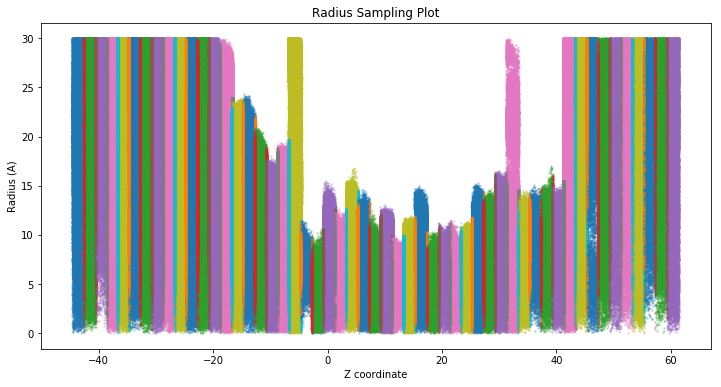

In [10]:
#window 1 to 6, rst07=138.6, rst08=6.74
#window 7 to 62, rst07=138.5, rst08=20.2
#window 63 to 69, rst07=153.2, rst08=20.2

#window 1-42, rst08
#window 43-69, rst07

#window 1-34, rst08 rst07=138.5, rst08=20.2
#window 35-56, rst07
#rMax=np.max([
    #np.sqrt(testData.Rst07_X**2+testData.Rst07_Y**2).max(),
    #np.sqrt(testData.Rst08_X**2+testData.Rst08_Y**2).max()
#])

rstMapper=np.concatenate([
    ['Rst08']*34,
    ['Rst07']*(55-34+1)
])
zWaterMap=np.zeros(56)
zWaterMap[0:34]=20.2
zWaterMap[34:56]=138.5

xWaterMap=np.zeros(56)
xWaterMap[0:34]=28.1
xWaterMap[34:56]=33.1

yWaterMap=np.zeros(56)
yWaterMap[0:34]=51.8
yWaterMap[34:56]=52.2
#zWaterMap[43:63]=138.5
#zWaterMap[63:70]=153.2

channelCenter=73.7
plt.figure(figsize=(12,6))
#zwater=1.26

for group in testData.query('Window < 34').groupby('Window'):
    plotName,plotData=group
    
    zwater=zWaterMap[plotName]
    ywater=yWaterMap[plotName]
    xwater=xWaterMap[plotName]
    rstName=rstMapper[plotName]
    
    transitData=plotData.query('Window != X_Index')
    centerData=plotData.query('Window == X_Index')

    plt.scatter(
        x=zwater+centerData[rstName+'_Z']-channelCenter,
        #y=np.sqrt((centerData['Rst06_X']**2) + (centerData['Rst06_Y']**2)),
        y=centerData['R'],
        s=2,
        #label='Window_%g Center Data'%plotName,
        alpha=.25)

    plt.scatter(
        x=zwater+transitData[rstName+'_Z']-channelCenter,
        #y=np.sqrt((transitData['Rst06_X']**2) + (transitData['Rst06_Y']**2)),\
        y=transitData['R'],
        s=2,
        #label='Window_%g Transit Data'%plotName,
        alpha=.25)
#plt.legend()
#plt.xlabel('Rst07_Z')
#plt.ylabel('sqrt(Rst07_X**2 + Rst07_Y**2)')
#plt.title("Window < 35")
#plt.show()

#zwater=147.9
#plt.figure(figsize=(12,9))
for group in testData.query('Window > 33').groupby('Window'):
    plotName,plotData=group
    
    zwater=zWaterMap[plotName]
    rstName=rstMapper[plotName]
    
    transitData=plotData.query('Window != X_Index')
    centerData=plotData.query('Window == X_Index')

    plt.scatter(
        x=zwater-centerData[rstName+'_Z']-channelCenter,
        #y=np.sqrt((centerData['Rst06_X']**2 ) + (centerData['Rst06_Y']**2)),
        y=centerData['R'],
        s=2,
        #label='Window_%g Center Data'%plotName,
        alpha=.25)

    plt.scatter(
        x=zwater-transitData[rstName+'_Z']-channelCenter,
        #y=np.sqrt((transitData['Rst06_X']**2) + (transitData['Rst06_Y']**2)),
        y=transitData['R'],
        s=2,
        #label='Window_%g Transit Data'%plotName,
        alpha=.25)
#plt.legend()
#plt.xlabel('Rst08_Z')
#plt.ylabel('sqrt(Rst08_X**2 + Rst08_Y**2)')

plt.title("Radius Sampling Plot")
plt.xlabel('Z coordinate')
plt.ylabel('Radius (A)')
#plt.vlines(x=20.2+testData.query('Window==16').Rst08_Z.max()-channelCenter,
          #ymin=0,ymax=rMax,label='before win16, r<50',color='Black')
#plt.vlines(x=20.2+testData.query('Window==45').Rst08_Z.max()-channelCenter,
          #ymin=0,ymax=rMax,label='win17 to 45, r<30',color='Black')

#plt.vlines(x=20.2+testData.query('Window==7').Rst08_Z.max()-channelCenter,
          #ymin=0,ymax=rMax,label='Rst08move',color='Black')
#plt.vlines(x=20.2+testData.query('Window==42').Rst08_Z.max()-channelCenter,
           #ymin=0,ymax=rMax,label='RstSwap',color='Brown')
#plt.vlines(x=138.5-testData.query('Window==62').Rst07_Z.max()-channelCenter,
           #ymin=0,ymax=rMax,label='Rst07move',color='Grey')
#plt.legend()
plt.show()

In [11]:
#channelCenter=73.7
#plt.figure(figsize=(12,6))
#zwater=20.2
#for group in testData.query('Window > 33').groupby('Window'):
   # plotName,plotData=group
   # transitData=plotData.query('Window != X_Index')
   # centerData=plotData.query('Window == X_Index')

   # plt.scatter(
   #     x=zwater+centerData.Rst07_Z-channelCenter,
   #     y=np.sqrt(centerData.Rst07_X**2 + centerData.Rst07_Y**2),
   #     s=2,label='Window_%g Center Data'%plotName,alpha=.25)

    #plt.scatter(
     #   x=zwater+transitData.Rst07_Z-channelCenter,
     #   y=np.sqrt(transitData.Rst07_X**2 + transitData.Rst07_Y**2),
     #   s=2,label='Window_%g Transit Data'%plotName,alpha=.25)
##plt.legend()
##plt.xlabel('Rst1_Z')
##plt.ylabel('sqrt(Rst1_X**2 + Rst1_Y**2)')
##plt.title("Window < 35")
##plt.show()



#zwater=138.5
##plt.figure(figsize=(12,9))
#for group in testData.query('Window < 34').groupby('Window'):
    #plotName,plotData=group
    #transitData=plotData.query('Window != X_Index')
    #centerData=plotData.query('Window == X_Index')

    #plt.scatter(
    #    x=zwater-centerData.Rst08_Z-channelCenter,
    #    y=np.sqrt(centerData.Rst08_X**2 + centerData.Rst08_Y**2),
    #    s=2,label='Window_%g Center Data'%plotName,alpha=.25)

    #plt.scatter(
    #    x=zwater-transitData.Rst08_Z-channelCenter,
    #    y=np.sqrt(transitData.Rst08_X**2 + transitData.Rst08_Y**2),
    #    s=2,label='Window_%g Transit Data'%plotName,alpha=.25)
##plt.legend()
##plt.xlabel('Rst2_Z')
##plt.ylabel('sqrt(Rst2_X**2 + Rst2_Y**2)')
##plt.title("Window > 34")
#plt.show()

In [12]:
testData.to_csv('Simulation_Milestone_Coordinate_Data.cAMP_newTransit.csv',index=False)

In [24]:
reload(analysis_functions)
milestoneData=analysis_functions.add_indexed_milestoning_analysis_columns(
    testData,
    windowColumn='Window',xIndexColumn='X_Index',frameCol='Frame',
    repColumn='Rep',groupingColumn=None,verbose=True,
    verboseLevel=0
)
print(milestoneData)

NameError: name 'analysis_functions' is not defined

In [11]:
indexedSimulationData=pd.read_csv('Simulation_Milestone_Coordinate_Data.cAMP_newTransit.csv')
indexedSimulationData=indexedSimulationData.query('(Window==0) and (Time <=1000)')
print(indexedSimulationData)

        Window  Rep    Time  Rst06_X  Rst06_Y  Rst07_Z  Rst08_Z  X_Index  \
0            0    1     0.0    4.291   17.350  107.903   10.456        0   
1            0    1   500.0    4.117   17.984  108.105   10.275        0   
2            0    1  1000.0    4.162   17.821  108.509    9.857        0   
9998         0    1     0.0   12.739   21.708  107.849   10.492        0   
9999         0    1   500.0   12.770   21.522  107.967   10.389        0   
10000        0    1  1000.0   12.449   21.574  107.926   10.416        0   
19787        0    1     0.0    7.249    6.244  107.620   10.712        0   
19788        0    1   500.0    7.796    6.707  107.523   10.798        0   
19789        0    1  1000.0    7.330    7.222  107.493   10.834        0   
29670        0    2     0.0    8.917   18.997  109.009    9.321        0   
29671        0    2   500.0    8.806   19.247  108.484    9.845        0   
29672        0    2  1000.0    9.333   19.236  108.667    9.683        0   
38015       

In [20]:
testData.head()

,Window,Rep,Time,Rst07_X,Rst07_Y,Rst07_Z,Rst08_X,Rst08_Y,Rst08_Z,X_Index
0,0,1,0,14.537,7.375,115.349,19.436,7.024,3.003,0
1,0,1,500,14.483,7.846,115.439,19.395,7.495,2.883,0
2,0,1,1000,14.393,6.804,115.193,19.287,6.483,3.174,0
3,0,1,1500,13.945,6.998,115.231,18.846,6.628,3.127,0
4,0,1,2000,13.969,6.345,115.515,18.882,6.001,2.839,0


In [3]:
testData=pd.read_csv('Simulation_Milestone_Coordinate_Data.K.csv')
testData.head()

,Window,Rep,Time,Rst1_X,Rst1_Y,Rst1_Z,Rst2_X,Rst2_Y,Rst2_Z,X_Index
0,0,1,0,16.259,8.703,5.887,17.809,8.429,140.836,0
1,0,1,834500,8.546,27.472,5.922,10.125,27.197,140.783,0
2,0,2,1667500,9.056,28.794,6.072,7.500,28.499,140.628,0
3,0,2,1667000,8.974,29.261,6.507,7.428,28.999,140.202,0
4,0,2,1666500,8.856,29.836,6.990,7.300,29.566,139.703,0


In [4]:
winMax={}
for window in [24,26]:
    winData=testData.query('Window == %g'%window)
    if window < 35:
        rstName='Rst1'
    else:
        rstName='Rst2'
        
    winMax[window]=(
        winData[rstName+'_X']**2+winData[rstName+'_Y']**2
    ).max()
    
for window in [25]:
    if window < 35:
        rstName='Rst1'
    else:
        rstName='Rst2'
        
    for transDelta in [-1,1]:
        badTransitionIndices=testData[
            (testData.Window==window) & \
            (testData.X_Index==(window+transDelta)) & \
            ((testData[rstName+'_X']**2+testData[rstName+'_Y']**2)>winMax[window+transDelta])
        ].index
        testData['X_Index'].loc[badTransitionIndices]=window

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



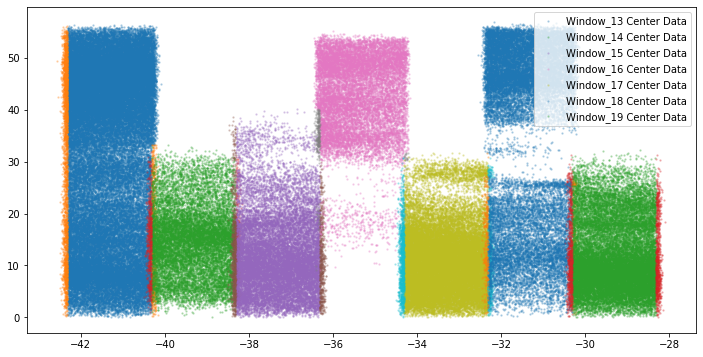

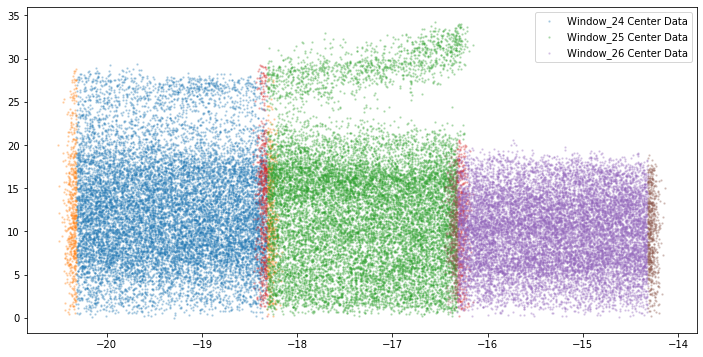

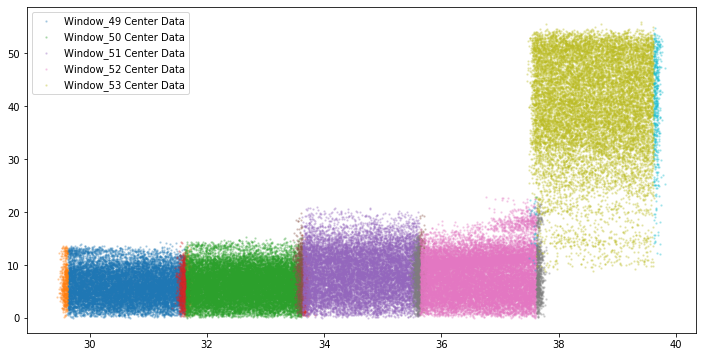

In [6]:
channelCenter=74.58
plt.figure(figsize=(12,6))
zwater=1.26
queryStr='(Window > 12) & (Window < 20)' #'Window < 35'
for group in testData.query(queryStr).groupby('Window'):
    plotName,plotData=group
    transitData=plotData.query('Window != X_Index')
    centerData=plotData.query('Window == X_Index')

    plt.scatter(
        x=zwater+centerData.Rst1_Z-channelCenter,
        y=np.sqrt(centerData.Rst1_X**2 + centerData.Rst1_Y**2),
        s=2,
        label='Window_%g Center Data'%plotName,
        alpha=.25)

    plt.scatter(
        x=zwater+transitData.Rst1_Z-channelCenter,
        y=np.sqrt(transitData.Rst1_X**2 + transitData.Rst1_Y**2),
        s=2,
        #label='Window_%g Transit Data'%plotName,
        alpha=.25)
plt.legend()
#plt.xlabel('Rst1_Z')
#plt.ylabel('sqrt(Rst1_X**2 + Rst1_Y**2)')
#plt.title("Window < 35")
plt.show()

plt.figure(figsize=(12,6))
zwater=1.26
queryStr='(Window > 23) & (Window < 27)' #'Window < 35'
for group in testData.query(queryStr).groupby('Window'):
    plotName,plotData=group
    transitData=plotData.query('Window != X_Index')
    centerData=plotData.query('Window == X_Index')

    plt.scatter(
        x=zwater+centerData.Rst1_Z-channelCenter,
        y=np.sqrt(centerData.Rst1_X**2 + centerData.Rst1_Y**2),
        s=2,
        label='Window_%g Center Data'%plotName,
        alpha=.25)

    plt.scatter(
        x=zwater+transitData.Rst1_Z-channelCenter,
        y=np.sqrt(transitData.Rst1_X**2 + transitData.Rst1_Y**2),
        s=2,
        #label='Window_%g Transit Data'%plotName,
        alpha=.25)
plt.legend()
#plt.xlabel('Rst1_Z')
#plt.ylabel('sqrt(Rst1_X**2 + Rst1_Y**2)')
#plt.title("Window < 35")
plt.show()

zwater=147.9
plt.figure(figsize=(12,6))
fig=go.Figure()
queryStr='(Window > 48) & (Window < 54)'#'Window < 35'
for group in testData.query(queryStr).groupby('Window'):
    plotName,plotData=group
    transitData=plotData.query('Window != X_Index')
    centerData=plotData.query('Window == X_Index')

    #fig.add_trace(
    #    go.Scatter(
    #        x=zwater-centerData.Rst2_Z-channelCenter,
    #        y=np.sqrt(centerData.Rst2_X**2 + centerData.Rst2_Y**2),
    #        opacity=.25
    #    )
    #)
    
    plt.scatter(
        x=zwater-centerData.Rst2_Z-channelCenter,
        y=np.sqrt(centerData.Rst2_X**2 + centerData.Rst2_Y**2),
        s=2,
        label='Window_%g Center Data'%plotName,
        alpha=.25)

    plt.scatter(
        x=zwater-transitData.Rst2_Z-channelCenter,
        y=np.sqrt(transitData.Rst2_X**2 + transitData.Rst2_Y**2),
        s=2,
        #label='Window_%g Transit Data'%plotName,
        alpha=.25)
plt.legend()
#plt.xlabel('Rst2_Z')
#plt.ylabel('sqrt(Rst2_X**2 + Rst2_Y**2)')
#plt.title("Window > 34")
plt.show()
#fig.show()

In [8]:
testData.to_csv('Simulation_Milestone_Coordinate_Data.K.csv')
testData.head()

,Window,Rep,Time,Rst1_X,Rst1_Y,Rst1_Z,Rst2_X,Rst2_Y,Rst2_Z,X_Index
0,0,1,0,16.259,8.703,5.887,17.809,8.429,140.836,0
1,0,1,834500,8.546,27.472,5.922,10.125,27.197,140.783,0
2,0,2,1667500,9.056,28.794,6.072,7.500,28.499,140.628,0
3,0,2,1667000,8.974,29.261,6.507,7.428,28.999,140.202,0
4,0,2,1666500,8.856,29.836,6.990,7.300,29.566,139.703,0


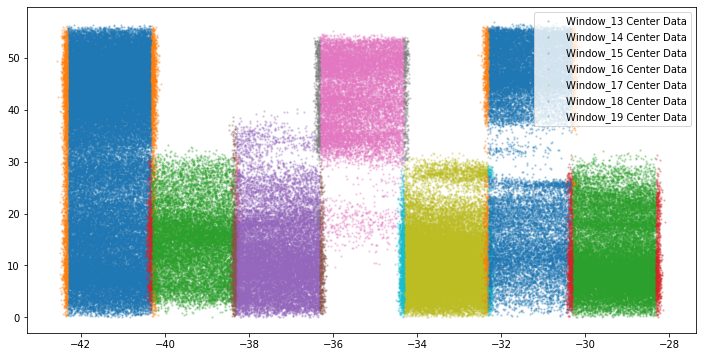

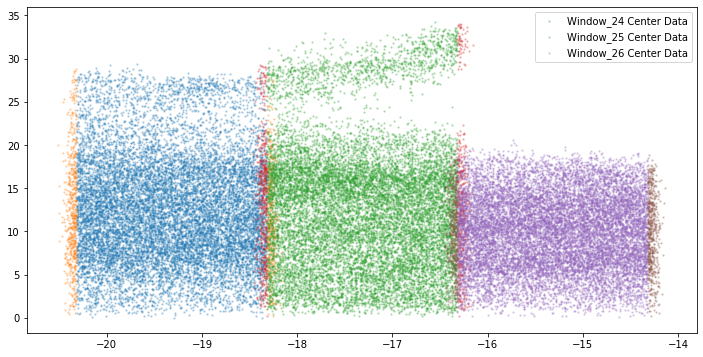

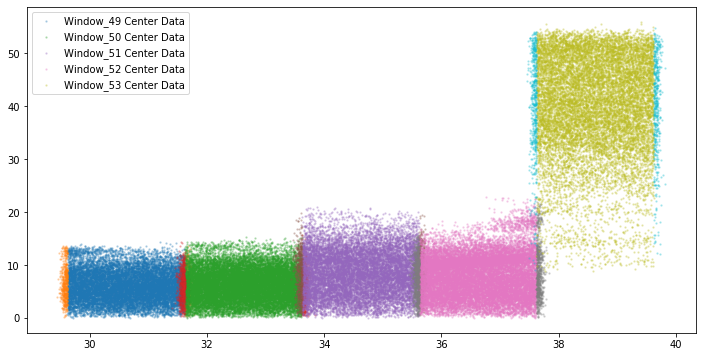

In [9]:
testData=pd.read_csv('Mileston_Joint_Data_table/Simulation_Milestone_Coordinate_Data.K.csv')
testData.head()

channelCenter=74.58
plt.figure(figsize=(12,6))
zwater=1.26
queryStr='(Window > 12) & (Window < 20)' #'Window < 35'
for group in testData.query(queryStr).groupby('Window'):
    plotName,plotData=group
    transitData=plotData.query('Window != X_Index')
    centerData=plotData.query('Window == X_Index')

    plt.scatter(
        x=zwater+centerData.Rst1_Z-channelCenter,
        y=np.sqrt(centerData.Rst1_X**2 + centerData.Rst1_Y**2),
        s=2,
        label='Window_%g Center Data'%plotName,
        alpha=.25)

    plt.scatter(
        x=zwater+transitData.Rst1_Z-channelCenter,
        y=np.sqrt(transitData.Rst1_X**2 + transitData.Rst1_Y**2),
        s=2,
        #label='Window_%g Transit Data'%plotName,
        alpha=.25)
plt.legend()
#plt.xlabel('Rst1_Z')
#plt.ylabel('sqrt(Rst1_X**2 + Rst1_Y**2)')
#plt.title("Window < 35")
plt.show()

plt.figure(figsize=(12,6))
zwater=1.26
queryStr='(Window > 23) & (Window < 27)' #'Window < 35'
for group in testData.query(queryStr).groupby('Window'):
    plotName,plotData=group
    transitData=plotData.query('Window != X_Index')
    centerData=plotData.query('Window == X_Index')

    plt.scatter(
        x=zwater+centerData.Rst1_Z-channelCenter,
        y=np.sqrt(centerData.Rst1_X**2 + centerData.Rst1_Y**2),
        s=2,
        label='Window_%g Center Data'%plotName,
        alpha=.25)

    plt.scatter(
        x=zwater+transitData.Rst1_Z-channelCenter,
        y=np.sqrt(transitData.Rst1_X**2 + transitData.Rst1_Y**2),
        s=2,
        #label='Window_%g Transit Data'%plotName,
        alpha=.25)
plt.legend()
#plt.xlabel('Rst1_Z')
#plt.ylabel('sqrt(Rst1_X**2 + Rst1_Y**2)')
#plt.title("Window < 35")
plt.show()

zwater=147.9
plt.figure(figsize=(12,6))
fig=go.Figure()
queryStr='(Window > 48) & (Window < 54)'#'Window < 35'
for group in testData.query(queryStr).groupby('Window'):
    plotName,plotData=group
    transitData=plotData.query('Window != X_Index')
    centerData=plotData.query('Window == X_Index')

    #fig.add_trace(
    #    go.Scatter(
    #        x=zwater-centerData.Rst2_Z-channelCenter,
    #        y=np.sqrt(centerData.Rst2_X**2 + centerData.Rst2_Y**2),
    #        opacity=.25
    #    )
    #)
    
    plt.scatter(
        x=zwater-centerData.Rst2_Z-channelCenter,
        y=np.sqrt(centerData.Rst2_X**2 + centerData.Rst2_Y**2),
        s=2,
        label='Window_%g Center Data'%plotName,
        alpha=.25)

    plt.scatter(
        x=zwater-transitData.Rst2_Z-channelCenter,
        y=np.sqrt(transitData.Rst2_X**2 + transitData.Rst2_Y**2),
        s=2,
        #label='Window_%g Transit Data'%plotName,
        alpha=.25)
plt.legend()
#plt.xlabel('Rst2_Z')
#plt.ylabel('sqrt(Rst2_X**2 + Rst2_Y**2)')
#plt.title("Window > 34")
plt.show()
#fig.show()